In [1]:
import rootutils

%load_ext autoreload
%autoreload 2

import hydra
import torch
import torch_geometric
from hydra import compose, initialize
from omegaconf import OmegaConf, open_dict

from topobenchmarkx.utils.config_resolvers import *



initialize(config_path="./configs", job_name="job")
cfg = compose(config_name="run.yaml", return_hydra_config=True)


/tmp/ipykernel_2999879/1443835557.py:16: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="./configs", job_name="job")


In [2]:
for key in cfg.transforms.keys():
    if 'G2S' in key:
        cfg.transforms[key].complex_dim = 3
        cfg.transforms[key].signed = False

In [3]:
# # Load curvature lifting

# #transforms/data_manipulations: node_degrees
# #transforms/data_manipulations@transforms.simplicial_curvature: simplicial_curvature

# OmegaConf.set_struct(cfg, True)

# graph2simplicial_lifting = cfg.transforms.get('graph2simplicial_lifting')
# del cfg.transforms.graph2simplicial_lifting

# rewire = OmegaConf.load("configs/transforms/data_manipulations/rewire.yaml")
# with open_dict(cfg):
#     cfg.transforms.RewireAFRC3 = rewire

# with open_dict(cfg):
#     cfg.transforms.graph2simplicial_lifting = graph2simplicial_lifting

# node_degrees_transform = OmegaConf.load("configs/transforms/data_manipulations/node_degrees.yaml")
# node_degrees_transform['selected_fields'].append('incidence')
# with open_dict(cfg):
#     cfg.transforms.node_degrees_transform = node_degrees_transform

# simplicial_curvature_transform = OmegaConf.load("configs/transforms/data_manipulations/simplicial_curvature.yaml")
# with open_dict(cfg):
#     cfg.transforms.simplicial_curvature_transform = simplicial_curvature_transform

# keel_selected_fiels = OmegaConf.load("configs/transforms/data_manipulations/keep_selected_fields.yaml")
# with open_dict(cfg):
#     cfg.transforms.keel_selected_fiels = keel_selected_fiels

In [4]:
# Instantiate and load dataset
#dataset = hydra.utils.instantiate(cfg.dataset, _recursive_=False)

dataset_loader = hydra.utils.instantiate(cfg.dataset.loader)
dataset, dataset_dir = dataset_loader.load()

In [5]:
from topobenchmarkx.data.preprocessor import PreProcessor
from topobenchmarkx.dataloader import TBXDataloader
# Preprocess dataset and load the splits
# log.info("Instantiating preprocessor...")
transform_config = cfg.get("transforms", None)
preprocessor = PreProcessor(dataset, dataset_dir, transform_config, force_reload=True)
dataset_train, dataset_val, dataset_test = (
    preprocessor.load_dataset_splits(cfg.dataset.split_params)
)
# Prepare datamodule
# log.info("Instantiating datamodule...")
if cfg.dataset.parameters.task_level in ["node", "graph"]:
    datamodule = TBXDataloader(
        dataset_train=dataset_train,
        dataset_val=dataset_val,
        dataset_test=dataset_test,
        **cfg.dataset.get("dataloader_params", {}),
    )
else:
    raise ValueError("Invalid task_level")

Processing...


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7bb9efbe7e90>>
Traceback (most recent call last):
  File "/home/lev/miniconda3/envs/tbx/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:
# Correct = {'iteration 1': 168, 'iteration 2': 235, 'iteration 3': 298}
# Wrong = {'iteration 1': 415,'iteration 2': 620, 'iteration 3': 933}

# # from two dicts make a pd.DataFrame
# import pandas as pd
# df = pd.DataFrame([Correct, Wrong], index=['Correct Eq.', 'Wrong Eq.'])
# df


,iteration 1,iteration 2,iteration 3
Correct Eq.,168,235,298
Wrong Eq.,415,620,933


In [7]:
if len(datamodule.train_dataloader()) > 1:
    data = torch_geometric.data.Data()

    d = {"0_cell_curvature": [], "1_cell_curvature": [], "2_cell_curvature": []}
    for batch in datamodule.train_dataloader():
        d["0_cell_curvature"].append(batch["0_cell_curvature"])
        d["1_cell_curvature"].append(batch["1_cell_curvature"])
        d["2_cell_curvature"].append(batch["2_cell_curvature"])

    for batch in datamodule.test_dataloader():
        d["0_cell_curvature"].append(batch["0_cell_curvature"])
        d["1_cell_curvature"].append(batch["1_cell_curvature"])
        d["2_cell_curvature"].append(batch["2_cell_curvature"])

    for batch in datamodule.val_dataloader():
        d["0_cell_curvature"].append(batch["0_cell_curvature"])
        d["1_cell_curvature"].append(batch["1_cell_curvature"])
        d["2_cell_curvature"].append(batch["2_cell_curvature"])

    data["0_cell_curvature"] = torch.cat(d["0_cell_curvature"], dim=0)
    data["1_cell_curvature"] = torch.cat(d["1_cell_curvature"], dim=0)
    data["2_cell_curvature"] = torch.cat(d["2_cell_curvature"], dim=0)


else:
    data = next(iter(datamodule.train_dataloader()))




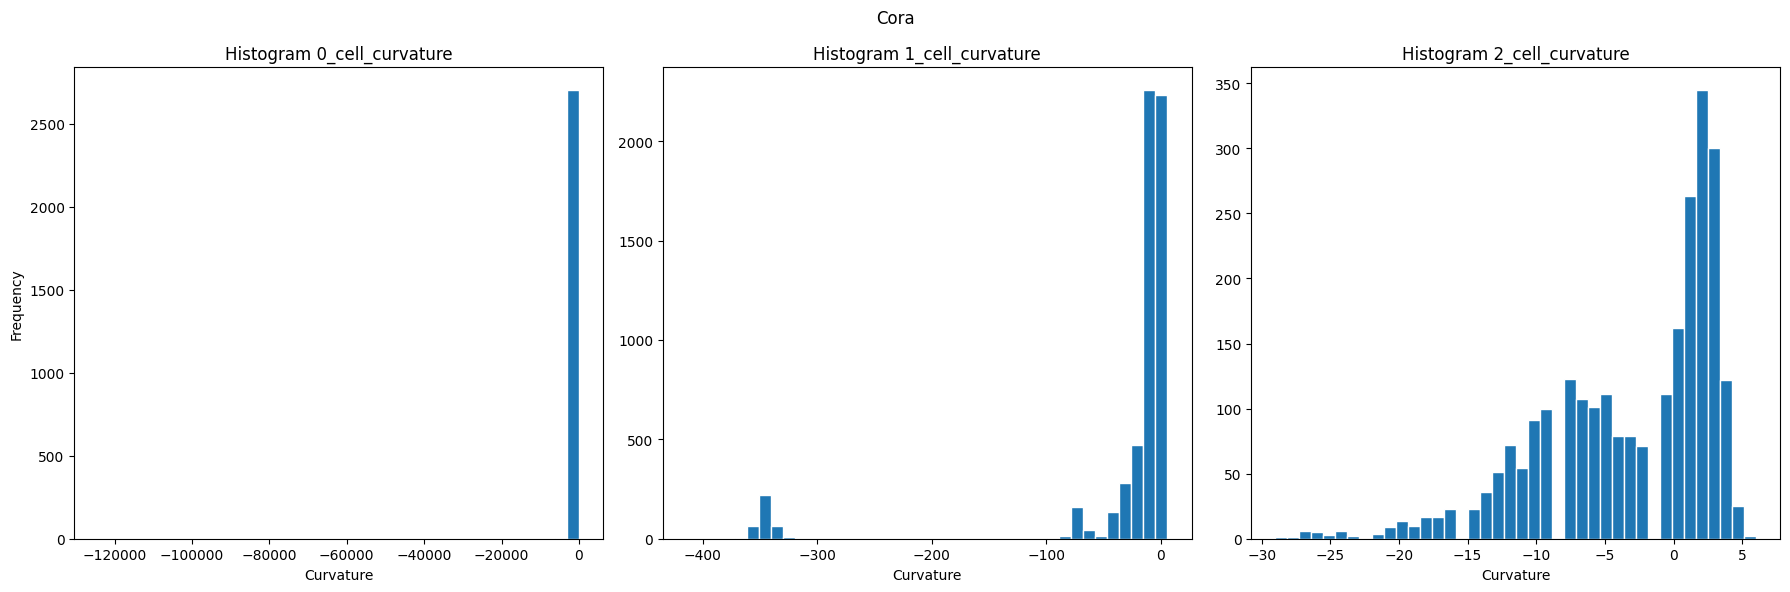

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def log10(a):
    b = np.zeros(a.shape)
    positive_idx = a>0
    zeros_idx = a==0
    b[positive_idx] = np.log10(a[positive_idx])
    b[~positive_idx] = np.log10(0+1e-6) - np.log10(-a[~positive_idx])
    b[zeros_idx] = np.log10(a[zeros_idx]+1e-6)
    return b

# Create subplots with one row and three columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
bins = 40

# Plot the histogram 0_cell_curvature and remove outliers
zero_cell_curvature = data["0_cell_curvature"].numpy().flatten()

axes[0].hist(zero_cell_curvature, bins=bins, edgecolor='white')
axes[0].set_title("Histogram 0_cell_curvature")

# Plot the histogram 1_cell_curvature and remove outliers
one_cell_curvature = data["1_cell_curvature"].numpy().flatten()
axes[1].hist(one_cell_curvature, bins=bins, edgecolor='white')
axes[1].set_title("Histogram 1_cell_curvature")

# Plot the histogram 2_cell_curvature and remove outliers
two_cell_curvature = data["2_cell_curvature"].numpy().flatten()
axes[2].hist(two_cell_curvature, bins=bins, edgecolor='white')
axes[2].set_title("Histogram 2_cell_curvature")






# # Add titpe to every subplot
# for i, ax in enumerate(axes):
#     ax.set_xlabel("Curvature")
#     ax.set_yscale("log")
#     if i == 0:
#         ax.set_ylabel("Frequency")

# Add titpe to every subplot
for i, ax in enumerate(axes):
    ax.set_xlabel("Curvature")
    # For each axes set mazimum y with respect to maximum value of the histogram
    #ax.set_ylim(0,150)
    if i == 0:
        ax.set_ylabel("Frequency")



# Add figure title
fig.suptitle(f"{cfg.dataset.loader.parameters.data_name}")

# Show the plots
plt.tight_layout()
#plt.savefig(f"plots/sanity_check/{cfg.dataset.loader.parameters.data_name}(norewire).png")
#plt.savefig(f"plots/sanity_check/{cfg.dataset.loader.parameters.data_name}({cfg.transforms.R.transform_name}, loops={cfg.transforms.R.loops}).png")
plt.show()
#save plots


In [ ]:
#f"plots/sanity_check/{cfg.dataset.loader.parameters.data_name}({cfg.transforms.R.transform_name}, loops={cfg.transforms.R.loops}).png"

In [ ]:
# # Check if graph is directed 
# import torch_geometric
# import torch_geometric.utils

# torch_geometric.utils.is_undirected(data.edge_index)



In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# def log10(a):
#     b = np.zeros(a.shape)
#     positive_idx = a>0
#     zeros_idx = a==0
#     b[positive_idx] = np.log10(a[positive_idx])
#     b[~positive_idx] = np.log10(0+1e-6) - np.log10(-a[~positive_idx])
#     b[zeros_idx] = np.log10(a[zeros_idx]+1e-6)
#     return b

# # Create subplots with one row and three columns
# fig, axes = plt.subplots(1, 3, figsize=(18, 6))


# # Plot the histogram 0_cell_curvature and remove outliers
# zero_cell_curvature = data["0_cell_curvature"].numpy().flatten()

# axes[0].hist(zero_cell_curvature, bins=100)
# axes[0].set_title("Histogram 0_cell_curvature")

# # Plot the histogram 1_cell_curvature and remove outliers
# one_cell_curvature = data["1_cell_curvature"].numpy().flatten()
# axes[1].hist(one_cell_curvature, bins=100)
# axes[1].set_title("Histogram 1_cell_curvature")

# # Plot the histogram 2_cell_curvature and remove outliers
# two_cell_curvature = data["2_cell_curvature"].numpy().flatten()
# axes[2].hist(two_cell_curvature, bins=100)
# axes[2].set_title("Histogram 2_cell_curvature")






# # Add titpe to every subplot
# for i, ax in enumerate(axes):
#     ax.set_xlabel("Curvature")
#     ax.set_yscale("log")
#     if i == 0:
#         ax.set_ylabel("Frequency")



# # Add figure title
# fig.suptitle(f"{cfg.dataset.loader.parameters.data_name}")

# # Show the plots
# plt.tight_layout()
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# def log10(a):
#     b = np.zeros(a.shape)
#     positive_idx = a>0
#     zeros_idx = a==0
#     b[positive_idx] = np.log10(a[positive_idx])
#     b[~positive_idx] = np.log10(0+1e-6) - np.log10(-a[~positive_idx])
#     b[zeros_idx] = np.log10(a[zeros_idx]+1e-6)
#     return b

# # Create subplots with one row and three columns
# fig, axes = plt.subplots(1, 3, figsize=(18, 6))


# # Plot the histogram 0_cell_curvature and remove outliers
# zero_cell_curvature = data["0_cell_curvature"].numpy().flatten()

# axes[0].hist(zero_cell_curvature, bins=100)
# axes[0].set_title("Histogram 0_cell_curvature")

# # Plot the histogram 1_cell_curvature and remove outliers
# one_cell_curvature = data["1_cell_curvature"].numpy().flatten()
# axes[1].hist(one_cell_curvature, bins=100)
# axes[1].set_title("Histogram 1_cell_curvature")

# # Plot the histogram 2_cell_curvature and remove outliers
# two_cell_curvature = data["2_cell_curvature"].numpy().flatten()
# axes[2].hist(two_cell_curvature, bins=100)
# axes[2].set_title("Histogram 2_cell_curvature")






# # Add titpe to every subplot
# for i, ax in enumerate(axes):
#     ax.set_xlabel("Curvature")
#     ax.set_yscale("log")
#     if i == 0:
#         ax.set_ylabel("Frequency")



# # Add figure title
# fig.suptitle(f"{cfg.dataset.loader.parameters.data_name}")

# # Show the plots
# plt.tight_layout()
# plt.show()

In [ ]:
# nodes_curvature_w = torch.cat([data['nodes_curvature_w'][key] for key in data['nodes_curvature_w'].keys()]).numpy()
# # Create subplots with one row and three columns
# fig, axes = plt.subplots(1, 1, figsize=(6, 6))
# axes.hist(nodes_curvature_w, bins=1000)
# # limit x axis to 500
# axes.set_xlim(-500, 100)